# Wi-Fi Network Security Threat Detection Using Machine Learning

In [2]:
# Define the path to the pcap files and the output directory
pcap_directory = "../datasets/wifi"
output_directory = "./model_output"

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scapy.utils import rdpcap
from scapy.layers.inet import IP
import joblib
import warnings
from datetime import datetime
import os
from scipy import stats

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, precision_recall_curve,
                           average_precision_score, confusion_matrix,
                           roc_curve, auc, silhouette_score)
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')

## 1. Load PCAP Files

In [4]:
def read_pcap(file_path):
    """
    Read pcap file and convert to DataFrame
    
    Parameters:
    file_path (str): Path to the PCAP file
    
    Returns:
    pandas.DataFrame: DataFrame containing packet information
    """
    try:
        packets = rdpcap(file_path)
        if not packets:
            print(f"Warning: {file_path} is empty")
            return pd.DataFrame()
            
        data = []
        
        for packet in packets:
            try:
                # Extract basic features
                timestamp = float(packet.time)
                if IP in packet:
                    src_ip = packet[IP].src
                    dst_ip = packet[IP].dst
                    protocol = packet[IP].proto
                    size = len(packet)
                    
                    data.append({
                        'timestamp': timestamp,
                        'src_ip': src_ip,
                        'dst_ip': dst_ip,
                        'protocol': protocol,
                        'size': size
                    })
            except Exception as e:
                continue
                
        return pd.DataFrame(data)
        
    except FileNotFoundError:
        print(f"Error: File {file_path} not found")
        return pd.DataFrame()
    except Exception as e:
        print(f"Error reading {file_path}: {str(e)}")
        return pd.DataFrame()

def process_multiple_pcaps(directory):
    """
    Process multiple pcap files from a directory
    
    Parameters:
    directory (str): Path to directory containing PCAP files
    
    Returns:
    pandas.DataFrame: Combined DataFrame with all packet data
    """
    if not os.path.exists(directory):
        raise FileNotFoundError(f"Directory {directory} not found")
        
    all_data = pd.DataFrame()
    
    for file in os.listdir(directory):
        if file.endswith('.pcap'):
            file_path = os.path.join(directory, file)
            print(f"Processing {file}...")
            df = read_pcap(file_path)
            
            if not df.empty:
                all_data = pd.concat([all_data, df])
    
    if all_data.empty:
        raise ValueError("No valid data found in any of the PCAP files")
        
    all_data = all_data.sort_values('timestamp')
    all_data['datetime'] = pd.to_datetime(all_data['timestamp'], unit='s')
    return all_data

df = process_multiple_pcaps(pcap_directory)

Processing ap_traffic_20241021_230344.pcap...
Processing ap_traffic_20241021_232304.pcap...
Processing ap_traffic_20241021_232521.pcap...
Processing ap_traffic_20241022_234507.pcap...
Processing ap_traffic_20241022_234522.pcap...
Processing ap_traffic_20241022_234654.pcap...
Processing ap_traffic_20241022_235036.pcap...
Processing ap_traffic_20241022_235548.pcap...
Processing ap_traffic_20241025_135801.pcap...
Processing ap_traffic_20241025_140650.pcap...
Processing ap_traffic_20241025_141331.pcap...
Processing ap_traffic_20241025_141947.pcap...
Processing ap_traffic_20241025_142325.pcap...
Processing ap_traffic_20241025_142646.pcap...
Processing ap_traffic_20241025_143050.pcap...
Processing ap_traffic_20241025_143554.pcap...
Processing ap_traffic_20241025_153720.pcap...
Processing ap_traffic_20241025_155930.pcap...
Processing ap_traffic_20241029_004819.pcap...
Processing ap_traffic_20241029_004837.pcap...
Processing ap_traffic_20241029_092603.pcap...
Processing ap_traffic_20241029_092

## 2. Visualize raw data

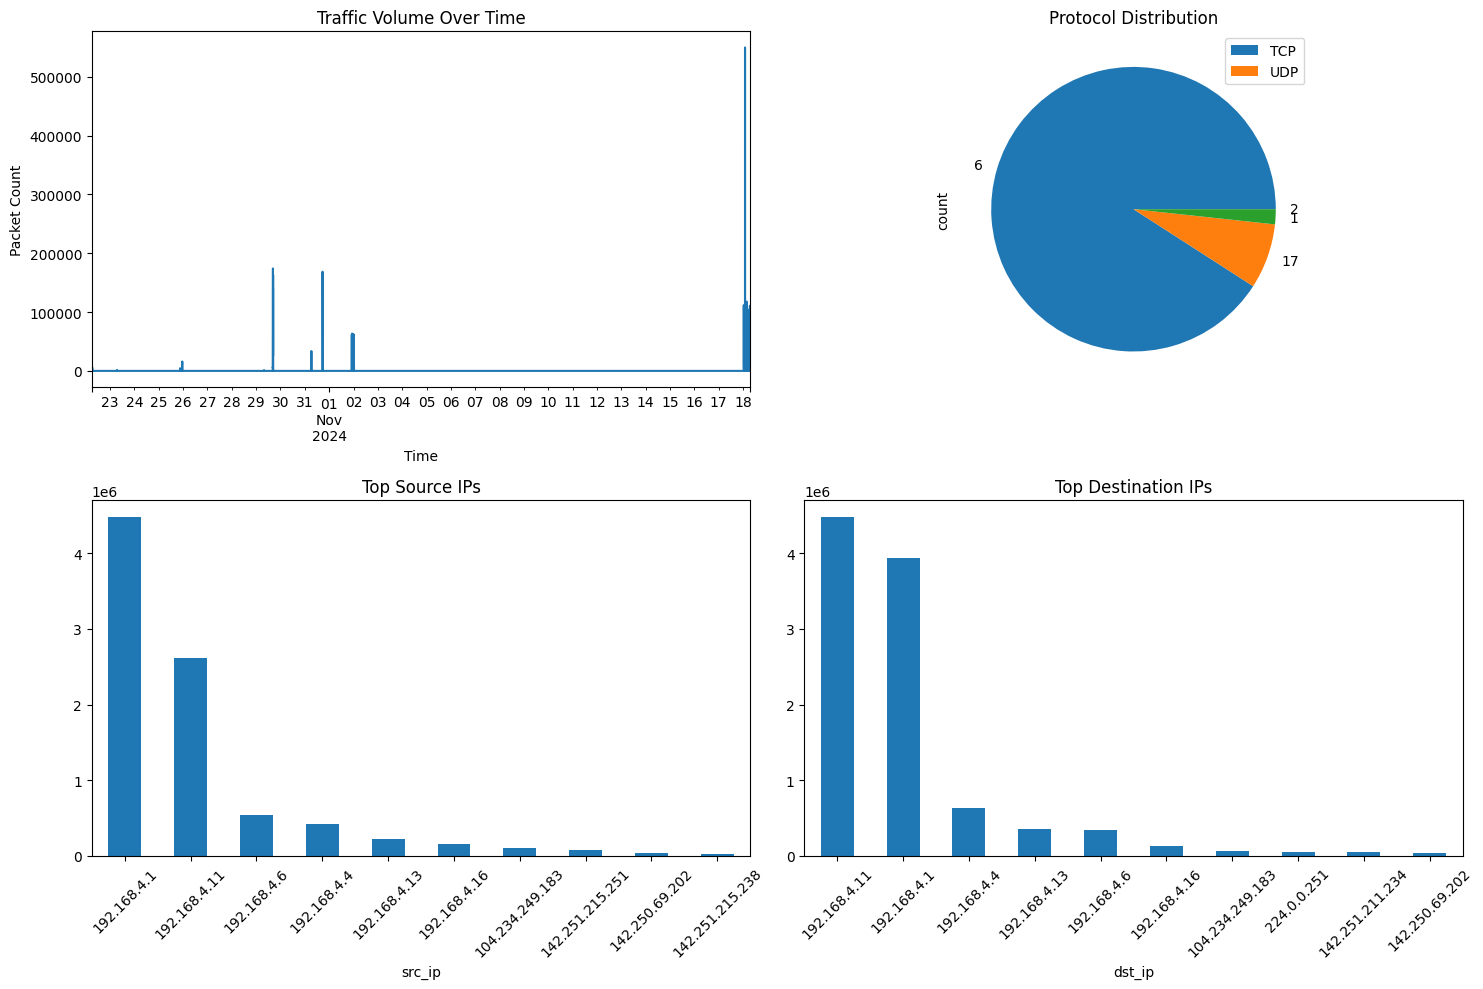

In [5]:
def plot_traffic_analysis(df):
    """
    Create various plots for traffic analysis
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing packet information
    
    Output:
    Displays four plots:
    - Traffic volume over time
    - Protocol distribution
    - Packet size distribution
    - Top source IPs
    """
    plt.figure(figsize=(15, 10))
    
    # Traffic volume over time
    plt.subplot(2, 2, 1)
    df.resample('1Min', on='datetime').size().plot()
    plt.title('Traffic Volume Over Time')
    plt.xlabel('Time')
    plt.ylabel('Packet Count')
    
    # Protocol distribution
    plt.subplot(2, 2, 2)
    df['protocol'].value_counts().plot(kind='pie')
    # Add legend with protocol names
    legend_labels = df['protocol'].map({6: 'TCP', 17: 'UDP'})
    plt.legend(legend_labels.value_counts().index)
    plt.title('Protocol Distribution')
    
    # Packet size distribution
    # plt.subplot(2, 2, 3)
    # sns.histplot(df['size'], bins=50)
    # plt.title('Packet Size Distribution')
    
    # Top source IPs
    plt.subplot(2, 2, 3)
    df['src_ip'].value_counts().head(10).plot(kind='bar')
    plt.title('Top Source IPs')
    plt.xticks(rotation=45)

    # Top destination IPs
    plt.subplot(2, 2,4)
    df['dst_ip'].value_counts().head(10).plot(kind='bar')
    plt.title('Top Destination IPs')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

plot_traffic_analysis(df)

## 3. Feature Engineering

In [31]:
def preprocess_features(features):
    """
    Preprocess features with comprehensive NaN handling
    """
    print("Starting preprocessing...")
    print(f"Initial shape: {features.shape}")
    
    # Remove timestamp for processing
    features_prep = features.copy()
    timestamp_col = None
    if 'timestamp' in features_prep.columns:
        timestamp_col = features_prep['timestamp']
        features_prep = features_prep.drop('timestamp', axis=1)
    
    # Print info about NaN values
    print("\nNaN values before handling:")
    print(features_prep.isna().sum())
    
    # Handle infinite values
    features_prep = features_prep.replace([np.inf, -np.inf], np.nan)
    
    # Handle NaN values with multiple strategies
    numeric_columns = features_prep.select_dtypes(include=[np.number]).columns
    
    for col in numeric_columns:
        # First try forward fill and backward fill
        features_prep[col] = features_prep[col].fillna(method='ffill').fillna(method='bfill')
        
        # If still have NaNs, fill with median
        if features_prep[col].isna().any():
            median_val = features_prep[col].median()
            if pd.isna(median_val):  # If median is also NaN
                features_prep[col] = features_prep[col].fillna(0)
            else:
                features_prep[col] = features_prep[col].fillna(median_val)
    
    # Handle any remaining NaN values
    features_prep = features_prep.fillna(0)
    
    print("\nNaN values after handling:")
    print(features_prep.isna().sum())
    
    # Remove constant columns
    constant_cols = [col for col in features_prep.columns if features_prep[col].nunique() == 1]
    if constant_cols:
        print(f"\nRemoving constant columns: {constant_cols}")
        features_prep = features_prep.drop(columns=constant_cols)
    
    # Handle zero variance
    zero_var_cols = features_prep.columns[features_prep.std() == 0]
    if len(zero_var_cols) > 0:
        print(f"\nRemoving zero variance columns: {zero_var_cols}")
        features_prep = features_prep.drop(columns=zero_var_cols)
    
    # Scale features
    scaler = RobustScaler()
    scaled_features = scaler.fit_transform(features_prep)
    
    # Final check for NaN
    if np.isnan(scaled_features).any():
        print("\nWarning: Still found NaN values after scaling!")
        # Replace any remaining NaN with 0 after scaling
        scaled_features = np.nan_to_num(scaled_features, 0)
    
    print(f"\nFinal shape: {scaled_features.shape}")
    return scaled_features, scaler, features_prep.columns

# Let's also modify the feature engineering to better handle potential NaN values
def create_advanced_features(df, window='1Min'):
    """Create features with NaN handling"""
    print("Creating features...")
    print(f"Initial DataFrame shape: {df.shape}")
    
    # Basic traffic features
    try:
        features = df.resample(window, on='datetime').agg({
            'size': ['count', 'mean', 'std', 'sum'],
            'src_ip': 'nunique',
            'dst_ip': 'nunique',
            'protocol': 'nunique'
        })
    except KeyError as e:
        print(f"Error with columns: {e}")
        print("Available columns:", df.columns)
        raise
    
    # Handle multi-level columns
    features.columns = ['packet_count', 'avg_packet_size', 'std_packet_size', 
                       'total_bytes', 'unique_src_ips', 'unique_dst_ips',
                       'protocol_diversity']
    
    # Initial NaN handling
    features = features.fillna(method='ffill').fillna(method='bfill').fillna(0)
    
    # Time-based features
    features['hour'] = features.index.hour
    features['is_business_hour'] = features['hour'].between(9, 17).astype(int)
    
    # Statistical features with careful NaN handling
    numeric_cols = features.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        roll = features[col].rolling(window=5, min_periods=1)
        features[f'{col}_rolling_mean'] = roll.mean().fillna(method='ffill').fillna(0)
        features[f'{col}_rolling_std'] = roll.std().fillna(method='ffill').fillna(0)
        
        # Careful z-score calculation
        mean = features[col].mean()
        std = features[col].std()
        if std != 0:
            features[f'{col}_zscore'] = ((features[col] - mean) / std).fillna(0)
        else:
            features[f'{col}_zscore'] = 0
    
    # Ratio features with zero handling
    features['packets_per_dst'] = features['packet_count'] / (features['unique_dst_ips'] + 1)
    features['bytes_per_packet'] = features['total_bytes'] / (features['packet_count'] + 1)
    
    # Protocol features
    try:
        protocol_counts = df.groupby(['datetime', 'protocol']).size().unstack(fill_value=0)
        protocol_ratios = protocol_counts.div(protocol_counts.sum(axis=1), axis=0).fillna(0)
        protocol_ratios.columns = [f'protocol_{col}_ratio' for col in protocol_ratios.columns]
        features = features.join(protocol_ratios)
    except Exception as e:
        print(f"Warning: Could not create protocol features: {e}")
    
    # Final NaN check
    if features.isna().any().any():
        print("\nWarning: NaN values found in features:")
        print(features.isna().sum()[features.isna().sum() > 0])
        features = features.fillna(0)
    
    print(f"Final features shape: {features.shape}")
    return features

# Preprocess data
features_df = create_advanced_features(df)
X_scaled, scaler, feature_names = preprocess_features(features_df)

# Verify no NaN values before model fitting
print("\nVerifying no NaN values:")
print("NaN values in scaled features:", np.isnan(X_scaled).sum())

Creating features...
Initial DataFrame shape: (10282162, 6)

protocol_1_ratio     38948
protocol_2_ratio     38948
protocol_6_ratio     38948
protocol_17_ratio    38948
dtype: int64
Final features shape: (38948, 42)
Starting preprocessing...
Initial shape: (38948, 42)

NaN values before handling:
packet_count                       0
avg_packet_size                    0
std_packet_size                    0
total_bytes                        0
unique_src_ips                     0
unique_dst_ips                     0
protocol_diversity                 0
hour                               0
is_business_hour                   0
packet_count_rolling_mean          0
packet_count_rolling_std           0
packet_count_zscore                0
avg_packet_size_rolling_mean       0
avg_packet_size_rolling_std        0
avg_packet_size_zscore             0
std_packet_size_rolling_mean       0
std_packet_size_rolling_std        0
std_packet_size_zscore             0
total_bytes_rolling_mean           0

## 4. Model Training

In [46]:
def train_multiple_models(X, contamination=0.1):
    models = {
        'isolation_forest': IsolationForest(
            contamination=contamination,
            n_estimators=300,
            max_samples='auto',
            max_features=0.8,
            bootstrap=True,
            n_jobs=-1,
            random_state=42
        ),
        'lof': LocalOutlierFactor(
            n_neighbors=20,
            contamination=contamination,
            novelty=True,
            n_jobs=-1
        )
    }
    
    results = {}
    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X)
        predictions = model.predict(X)
        scores = -model.score_samples(X) if name != 'lof' else -model.negative_outlier_factor_
        
        try:
            silhouette = silhouette_score(X, predictions)
            results[name] = {
                'model': model,
                'silhouette': silhouette,
                'predictions': predictions,
                'scores': scores
            }
        except:
            continue
    
    return results

# Train models
model_results = train_multiple_models(X_scaled)

Training isolation_forest...
Training lof...


In [47]:
# Select best model
best_model_name = max(model_results.items(), key=lambda x: x[1]['silhouette'])[0]
best_model = model_results[best_model_name]['model']

print(f"Best model: {best_model_name}")

Best model: lof


## 5. Synthetic Evaluation

In [48]:
def inject_synthetic_anomalies(X, feature_names, anomaly_percentage=0.1):
    X_anomaly = X.copy()
    n_samples = len(X)
    n_anomalies = int(n_samples * anomaly_percentage)
    
    indices = np.random.choice(n_samples, size=n_anomalies, replace=False)
    labels = np.zeros(n_samples)
    
    for idx in indices:
        anomaly_type = np.random.choice(['extreme', 'mixed', 'subtle'])
        
        if anomaly_type == 'extreme':
            X_anomaly[idx] *= np.random.uniform(5, 10)
        elif anomaly_type == 'mixed':
            cols = np.random.choice(len(feature_names), size=2, replace=False)
            X_anomaly[idx, cols] *= np.random.uniform(2, 4)
        else:  # subtle
            cols = np.random.choice(len(feature_names), size=3, replace=False)
            X_anomaly[idx, cols] *= np.random.uniform(1.5, 2)
            
        labels[idx] = 1
        
    return X_anomaly, labels

# Create synthetic dataset
X_test, y_test = inject_synthetic_anomalies(X_scaled, feature_names)

## 6. Evaluate model

In [49]:
def evaluate_model(model, X, y_true):
    # Get predictions
    y_pred = model.predict(X)
    scores = -model.score_samples(X)
    
    # Convert predictions from -1/1 to 0/1
    y_pred_binary = (y_pred == -1).astype(int)
    
    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred_binary),
        'precision': precision_score(y_true, y_pred_binary),
        'recall': recall_score(y_true, y_pred_binary),
        'f1': f1_score(y_true, y_pred_binary),
        'roc_auc': roc_auc_score(y_true, scores),
        'avg_precision': average_precision_score(y_true, scores)
    }
    
    # Calculate confusion matrix metrics
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
    metrics.update({
        'fpr': fp / (fp + tn),
        'fnr': fn / (fn + tp),
        'tpr': tp / (tp + fn),
        'specificity': tn / (tn + fp)
    })
    
    return metrics, scores, y_pred_binary

# Evaluate best model
metrics, scores, predictions = evaluate_model(best_model, X_test, y_test)

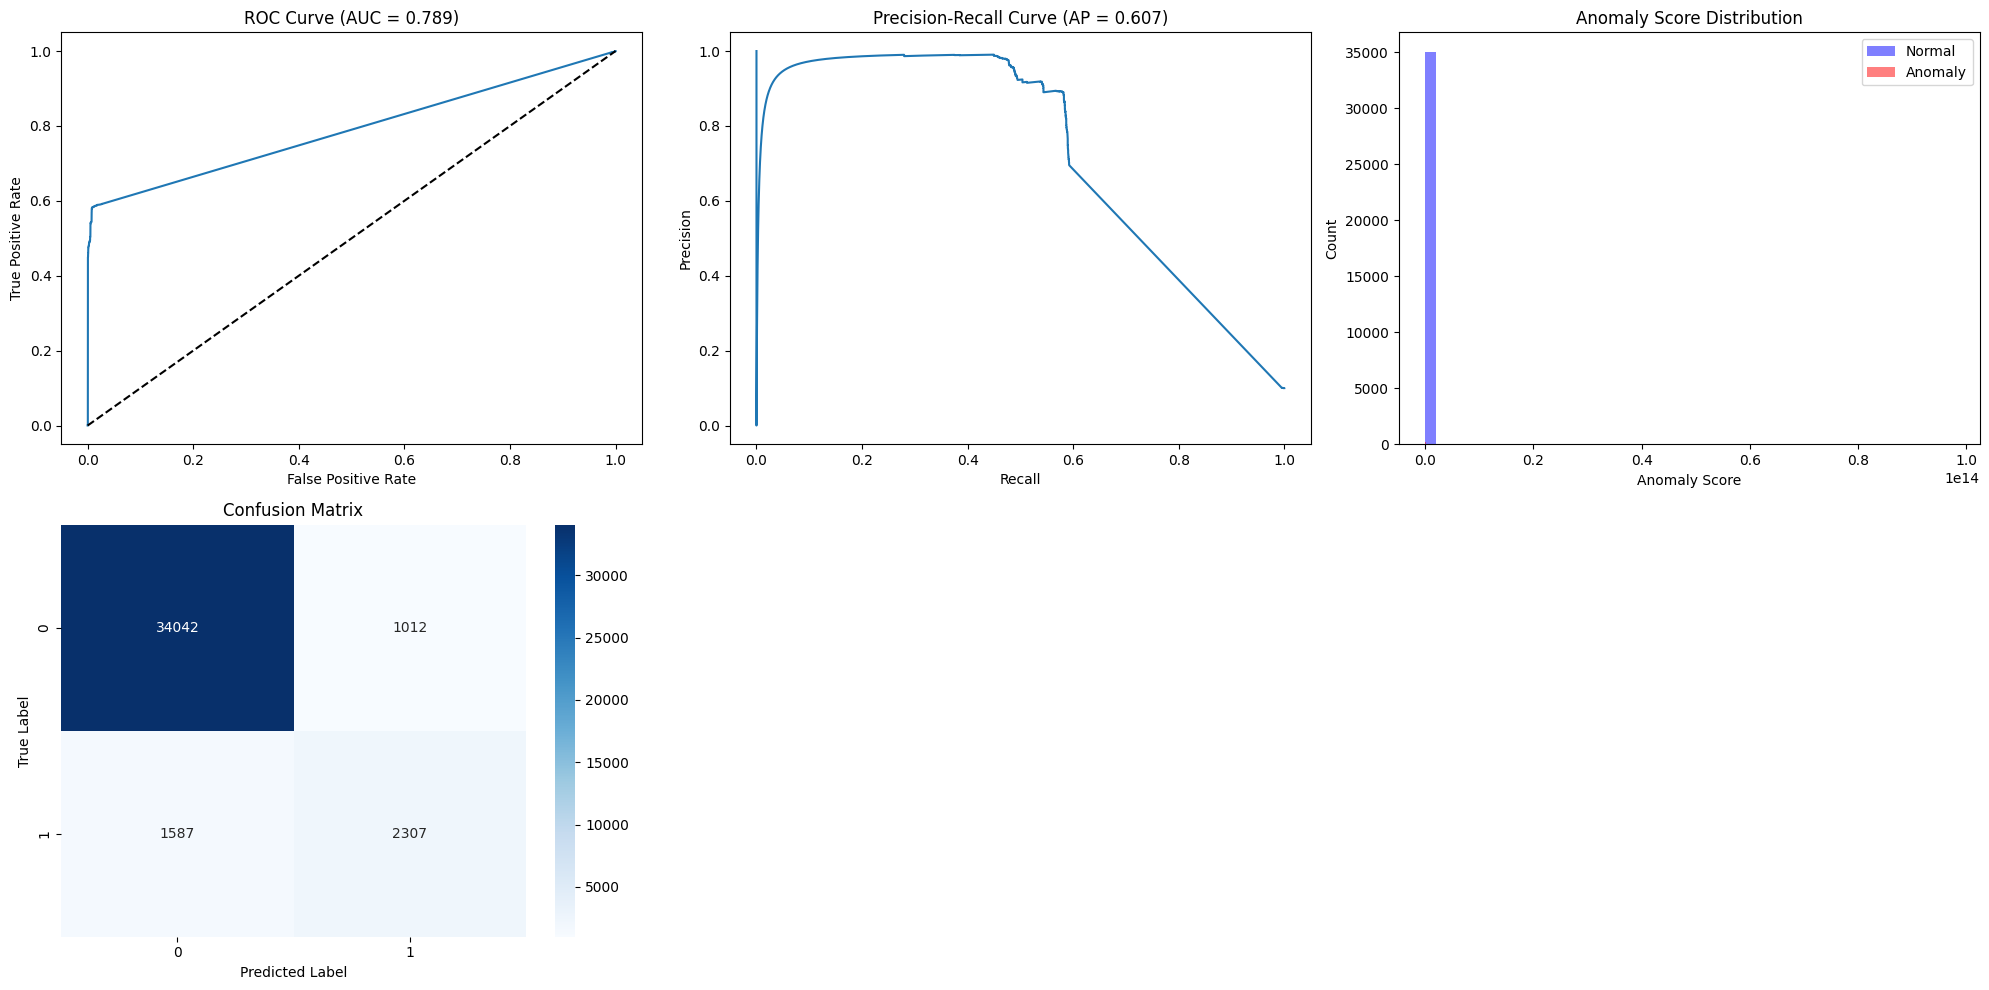


Model Performance Metrics:
--------------------------------------------------
Accuracy: 0.933
Precision: 0.695
Recall: 0.592
F1: 0.640
Roc Auc: 0.789
Avg Precision: 0.607
Fpr: 0.029
Fnr: 0.408
Tpr: 0.592
Specificity: 0.971


In [50]:
def plot_evaluation_results(y_true, y_pred, scores, metrics):
    fig = plt.figure(figsize=(20, 10))
    
    # 1. ROC Curve
    plt.subplot(2, 3, 1)
    fpr, tpr, _ = roc_curve(y_true, scores)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'ROC Curve (AUC = {metrics["roc_auc"]:.3f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    # 2. Precision-Recall Curve
    plt.subplot(2, 3, 2)
    precision, recall, _ = precision_recall_curve(y_true, scores)
    plt.plot(recall, precision)
    plt.title(f'Precision-Recall Curve (AP = {metrics["avg_precision"]:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
    # 3. Score Distribution
    plt.subplot(2, 3, 3)
    plt.hist(scores[y_true == 0], bins=50, alpha=0.5, label='Normal', color='blue')
    plt.hist(scores[y_true == 1], bins=50, alpha=0.5, label='Anomaly', color='red')
    plt.title('Anomaly Score Distribution')
    plt.xlabel('Anomaly Score')
    plt.ylabel('Count')
    plt.legend()
    
    # 4. Confusion Matrix
    plt.subplot(2, 3, 4)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()

# Plot results
plot_evaluation_results(y_test, predictions, scores, metrics)

# Print metrics
print("\nModel Performance Metrics:")
print("-" * 50)
for metric, value in metrics.items():
    print(f"{metric.replace('_', ' ').title()}: {value:.3f}")

## 7. Save Model

In [39]:
def save_model(model, scaler, output_dir):
    """
    Save the trained model and scaler
    
    Parameters:
    model: Trained Isolation Forest model
    scaler: Fitted StandardScaler
    output_dir (str): Directory to save model files
    """
    os.makedirs(output_dir, exist_ok=True)
    
    joblib.dump(model, os.path.join(output_dir, 'wifi_isolation_forest_model.joblib'))
    joblib.dump(scaler, os.path.join(output_dir, 'wifi_scaler.joblib'))
    print(f"Model and scaler saved to {output_dir}")

    # Save feature names
    pd.Series(feature_names).to_csv(
        os.path.join(output_dir, 'wifi_feature_names.csv'),
        index=False
    )

    # Save evaluation results
    pd.DataFrame([metrics]).to_csv(
        os.path.join(output_dir, 'wifi_evaluation_results.csv'),
        index=False
    )

save_model(best_model, scaler, output_directory)

Model and scaler saved to ./model_output
